# Parallax Correction

For geostationary satellite data in particular, the affects of parallax are a big issue. Because the Earth is (nearly) round and geostationary satellites are very far away (35,786 km), the apparent position of objects above the surface of the earth (such as clouds) can be considerably displaced from their actual ground-relative location. This displacement is a function of the position of the cloud relative to the satellite (i.e., the satellite-viewing angle) and a function of the height of the cloud above the surface of the Earth. These figures from the University of Wyoming help to illustrate.

<img src="https://github.com/jlc248/satellite-resources/blob/main/docs/_static/images/parallax_1.gif?raw=true">

A geostationary satellite’s nadir point is at the equator. At this point, high clouds and low clouds have no displacement. But everywhere else, high clouds are displaced more than low clouds. Comparing the high cloud and low cloud in approximately the mid-latitudes, we can see that the cloud edge closer to the equator is displaced much further poleward (i.e., away from the satellite) for the high cloud than the low cloud. In this example, assuming an 18-km cloud top and a 3-km cloud top at a viewing angle of 52 degrees, the parallax displacements are 30 km and 5 km, respectively. Moving that same low cloud closer to the pole, the parallax displacement accelerates quickly.

<img src="https://github.com/jlc248/satellite-resources/blob/main/docs/_static/images/parallax_2.png?raw=true" width=500>

From this graph, we can see that the normalized cloud offset increases exponentially as the angular distance from nadir increases. For example, for a cloud top at 10 km AGL, and a satellite-viewing angle 60 degrees, the displacement is `10 * 2.6 = 26 km`.

To visualize the effects of parallax in GOES data, this [CIMSS page](https://cimss.ssec.wisc.edu/goes/webapps/parallax/overview.html) is a handy resource. For instance, the image below shows the relative effects of parallax over the CONUS sector for a cloud at 30 kft (the vectors are exaggerated).

<img src="https://github.com/jlc248/satellite-resources/blob/main/docs/_static/images/parallax_3.png?raw=true" width=800>

How do we perform a parallax correction? There are several options:

1.   Assume a constant cloud height
2.   Assume a cloud height that varies based on location and season
3.   Use something like the GOES-R cloud-top height product

The simplest option is to assume a constant cloud height. It is also quite fast.

## Correction with constant cloud-height assumption

Now we will perform a parallax correction with a constant cloud-height assumption. This is a fast approach, but obviously will have larger errors the further the cloud height is from our assumed height. Since we're mostly interested in convective clouds, using a cloud height of **9000 m** usually works well.


### Install Libraries

In [ ]:
!pip --quiet install s3fs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.2/77.2 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 75.1 MB/s eta 0:00:00


### Import Libraries

In [ ]:
import numpy as np
import s3fs
import xarray as xr
import datetime
import matplotlib.pyplot as plt
import logging
%matplotlib inline

### Download data

Here we download some ABI L1b data using xarray and s3fs. We are only downloading 10.35-µm data.

In [ ]:
fs = s3fs.S3FileSystem(anon=True) #connect to s3 bucket!

abidt = datetime.datetime(2024,8,13,18,41)

file_location = fs.glob(abidt.strftime('s3://noaa-goes16/ABI-L1b-RadC/%Y/%j/%H/*C13*_s%Y%j%H%M*.nc'))
file_ob = [fs.open(file) for file in file_location]
ds = xr.open_mfdataset(file_ob,combine='nested',concat_dim='time')

### Visualize Data

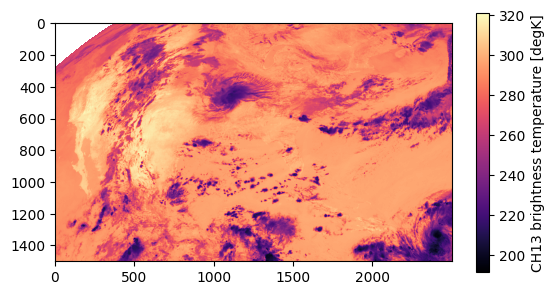

In [ ]:
ch13 = ds['Rad'][0].data.compute()
# Convert to brightness temperature
# First get some constants
planck_fk1 = ds['planck_fk1'].data[0]
planck_fk2 = ds['planck_fk2'].data[0]
planck_bc1 = ds['planck_bc1'].data[0]
planck_bc2 = ds['planck_bc2'].data[0]
ch13 = (planck_fk2 / (np.log((planck_fk1 / ch13) + 1)) - planck_bc1) / planck_bc2

plt.imshow(ch13, cmap='magma')
plt.colorbar(label="CH13 brightness temperature [degK]", shrink=0.7)
plt.show()

Good, we can visualize the 10.35-µm BT. Now to correct it.

Below is the code to perform parallax correction with a constant cloud height. We only need to supply the `lats`, the `lons`, the longitude position of the satellite `satlon`, the constant cloud height `elevation`, and a flag to return the data `return_dict`.

In [ ]:
# @title
def plax(
    lats,
    lons,
    satlon=-75.2,
    elevation=9000.0,
    gip=None,
    return_dict=False,
    write_plax_file=False,
):
    """
    This function will return the parallax-corrected lats and lons (if return_dict=True).
    Optionally, it will write a pickle file with the parallax-corrected info.

    Args:
        lats: Numpy array of latitudes
        lons: Numpy array of longitudes
        satlon: The longitude of the geostationary satellite. Default = 75.2
        elevation: Constant cloud height (in meters above earth's surface). Default = 9000.0
        gip: A optional dictionary with projection info such as "semi_major_axis", "semi_minor_axis", and "perspective_point_height"
        write_plax_file: Write out a pickle file with parallax-corrected info. Default = False.

    Returns:
        return_dict: Return a dictionary with the parallax-corrected lats and lons. Default: False


    """
    # elevation is height of object, in meters, above earth surface (assuming constant height)
    # ----->Local constants
    if np.ma.is_masked(lats) or np.ma.is_masked(lons):
        mask = lats.mask  # to be used later
        masked = True
    else:
        masked = False

    logging.info(
        f"Performing parallax correction with satlon = {satlon} deg. and elevation = {elevation} m."
    )
    to_radians = np.pi / 180.0  # Conversion to radians from degrees
    to_degrees = 180.0 / np.pi  # Conversion to degrees from radians
    right_angle = np.pi / 2.0  # Right angle in radians for reference
    satlat = 0.0  # Satellite latitude; 0.0 for GEOs
    satlat_rad = satlat * to_radians  # Satellite latitude in radians
    if gip:
        earth_radius = (gip["semi_major_axis"] + gip["semi_minor_axis"]) / 2.0
        altitude = earth_radius + gip["perspective_point_height"]
    else:
        earth_radius = 6371009.0  # Mean earth radius, in meters, based on WGS-84 data
        altitude = 42166111.9  # Distance of satellite, in meters, from center of earth

    earth_radius_elevation = (
        earth_radius + elevation
    )  # Mean radius of the earth plus height of object above surface, in meters
    satlon_rad = satlon * to_radians

    # ----->General variables defined
    datalat_rad = lats * to_radians
    datalon_rad = lons * to_radians

    datalat_pc_rad = np.zeros(lats.shape) - 999.0
    datalon_pc_rad = np.zeros(lons.shape) - 999.0

    # ----->Calculate the distance between satellite nadir and base of object (using haversine formula)
    londiff = satlon_rad - datalon_rad
    latdiff = satlat_rad - datalat_rad

    centralangle = 2.0 * np.arcsin(
        np.sqrt(
            (np.sin(latdiff / 2.0)) ** 2
            + np.cos(satlat_rad) * np.cos(datalat_rad) * (np.sin(londiff / 2.0)) ** 2
        )
    )
    gcdistance = earth_radius * centralangle

    # ----->Calculate the central angle that subtends the great circle distance between nadir and true position
    # ...First find distance between satellite and non-true position using the Law of Cosines
    satviewdist = np.sqrt(
        altitude**2
        + earth_radius**2
        - 2.0 * altitude * earth_radius * np.cos(centralangle)
    )

    # ...Then find the satellite view angle from nadir on great circle plane also using the Law of Cosines
    satviewangle = np.arccos(
        (earth_radius**2 - altitude**2 - satviewdist**2)
        / (-2.0 * altitude * satviewdist)
    )

    # ...Then find the adjusted central angle for parallax
    # First find angle between satellite and center of the earth where the true position is the vertex using the Law of Sines
    angleSNO = np.arcsin((altitude * np.sin(satviewangle)) / earth_radius_elevation)
    ind = np.where(angleSNO < right_angle)
    if len(ind) > 0:
        angleSNO[ind] = np.pi - angleSNO[ind]

    # Then calculate adjusted central angle for parallax using identity that all angles of a triangle add up to pi radians
    sat_true_centralangle = np.pi - angleSNO - satviewangle
    sat_true_gcdist = earth_radius * sat_true_centralangle

    # ----->Calculate latitudinal component of parallax correction (assumes great circle is equivalent to satellite meridian)
    # ...First find distance between satellite and non-true latitude position using the Law of Cosines
    satviewdist_lat = np.sqrt(
        altitude**2
        + earth_radius**2
        - 2.0 * altitude * earth_radius * np.cos(datalat_rad)
    )

    # ...Then find the satellite view zenith angle from nadir also using the Law of Cosines
    satviewangle_lat = np.arccos(
        (earth_radius**2 - altitude**2 - satviewdist_lat**2)
        / (-2.0 * altitude * satviewdist_lat)
    )

    # ...Then find the adjusted zenith angle for parallax
    # First find angle between satellite and center of the earth where the true position is the vertex using the Law of Sines
    angleSNO_lat = np.arcsin(
        (altitude * np.sin(satviewangle_lat)) / earth_radius_elevation
    )
    ind = np.where(angleSNO_lat < right_angle)
    if len(ind[0]) > 0:
        angleSNO_lat[ind] = np.pi - angleSNO_lat[ind]

    # Then calculate adjusted zenith angle for parallax using identity that all angles of a triangle add up to pi radians
    ind = np.where(lats > satlat)
    other_ind = np.where(lats <= satlat)
    if len(ind[0]) > 0:
        datalat_pc_rad[ind] = np.pi - angleSNO_lat[ind] - satviewangle_lat[ind]

    if len(other_ind) > 0:
        datalat_pc_rad[other_ind] = (
            angleSNO_lat[other_ind] + satviewangle_lat[other_ind] - np.pi
        )

    # ----->Calculate longitudinal component of parallax correction (using haversine formula)
    latdiff_pc = satlat_rad - datalat_pc_rad
    ind = np.where(lons < satlon)
    other_ind = np.where(lons >= satlon)
    if len(ind[0]) > 0:
        datalon_pc_rad[ind] = satlon_rad - 2.0 * np.arcsin(
            np.sqrt(
                np.abs(
                    (
                        (np.sin(sat_true_centralangle[ind] / 2.0)) ** 2
                        - (np.sin(latdiff_pc[ind] / 2.0)) ** 2
                    )
                    / (np.cos(satlat_rad) * np.cos(datalat_pc_rad[ind]))
                )
            )
        )
    if len(other_ind[0]) > 0:
        datalon_pc_rad[other_ind] = satlon_rad + 2.0 * np.arcsin(
            np.sqrt(
                np.abs(
                    (
                        (np.sin(sat_true_centralangle[other_ind] / 2.0)) ** 2
                        - (np.sin(latdiff_pc[other_ind] / 2.0)) ** 2
                    )
                    / (np.cos(satlat_rad) * np.cos(datalat_pc_rad[other_ind]))
                )
            )
        )

    # ----->Place parallax-corrected latitudes and longitudes into respective arrays
    lat_pc = datalat_pc_rad * to_degrees
    lon_pc = datalon_pc_rad * to_degrees

    if masked:
        lat_pc = np.ma.MaskedArray(lat_pc, mask=mask)
        lon_pc = np.ma.MaskedArray(lon_pc, mask=mask)


    if not (return_dict) and not (write_plax_file):
        logging.info("Process ended.")
        return lat_pc, lon_pc

    else:
        # NB: NW corner should be the 0,0 point for your lats and lons
        logging.info("Getting new xinds (for lons) and yinds (for lats)")

        latdiff = lats - lat_pc
        londiff = lons - lon_pc
        nlats, nlons = lons.shape
        xind = np.zeros((nlats, nlons), dtype=int)
        yind = np.zeros((nlats, nlons), dtype=int)

        mask = (
            np.ma.is_masked(lats[1:-1, 1:-1])
            | np.ma.is_masked(lats[:-2, 1:-1])
            | np.ma.is_masked(lats[2:, 1:-1])
            | np.ma.is_masked(lons[1:-1, 1:-1])
            | np.ma.is_masked(lons[1:-1, :-2])
            | np.ma.is_masked(lons[1:-1, 2:])
        )

        dy = (lats[:-2, 1:-1] - lats[2:, 1:-1]) / 2.0
        dx = (lons[1:-1, :-2] - lons[1:-1, 2:]) / 2.0

        latshift = np.round(latdiff[1:-1, 1:-1] / dy)  # number of pixels to shift
        lonshift = np.round(londiff[1:-1, 1:-1] / dx)  # number of pixels to shift

        new_elem = np.arange(1, nlons - 1) + lonshift  # add vector to each column
        new_line = (
            np.arange(1, nlats - 1).reshape(-1, 1) + latshift
        )  # reshape so that we add to each row

        xind[1:-1, 1:-1] = new_elem
        yind[1:-1, 1:-1] = new_line

        logging.info("Accounting for pixels off the grid")

        # Account for edges
        yind[0, :] = yind[1, :]
        yind[-1, :] = yind[-2, :]
        yind[:, 0] = yind[:, 1]
        yind[:, -1] = yind[:, -2]
        xind[0, :] = xind[1, :]
        xind[-1, :] = xind[-2, :]
        xind[:, 0] = xind[:, 1]
        xind[:, -1] = xind[:, -2]

        # Account for pixels off the grid
        yind[yind >= nlats] = nlats - 1
        yind[yind < 0] = 0
        xind[xind >= nlons] = nlons - 1
        xind[xind < 0] = 0

        outdata = {
            "xind": xind,
            "yind": yind,
            "lat_orig": lats,
            "lon_orig": lons,
            "lat_pc": lat_pc,
            "lon_pc": lon_pc,
            "elevation_in_m": elevation,
            "satlon": round(satlon, 1),
            "dx": f"{np.round(lons[0,1] - lons[0,0],2) * 100}km",
            "dy": f"{np.round(lats[0,0] - lats[1,0],2) * 100}km",
        }

        # import matplotlib.pyplot as plt
        # fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(16,9))
        # im = ax[0].imshow(latshift); ax[0].set_title('latshift'); plt.colorbar(im,ax=ax[0],shrink=0.5)
        # im = ax[1].imshow(lonshift); ax[1].set_title('lonshift'); plt.colorbar(im,ax=ax[1],shrink=0.5)
        # plt.savefig('tmp.png',bbox_inches='tight')
        # sys.exit()

        if return_dict:
            return outdata

        if write_plax_file:
            outfile = "PLAX_" + "{:.1f}".format(satlon) + f"_{int(elevation)}m.pkl"
            pickle.dump(outdata, open(outfile, "wb"))
            logging.info(f"Wrote out {outfile}")

Before we can test out the `plax` function, we need some latitudes and longitudes. We can use `pyproj` to definte our geostationary projection and compute `lats` and `lons` from `x` and `y`.  To get the proper projection coordinates from the ABI L1b files, we need to first multiply `x` and `y` by the satellite height.

In [ ]:
import pyproj

sat_height = ds.goes_imager_projection.perspective_point_height
sat_longitude = ds.goes_imager_projection.longitude_of_projection_origin
x = ds['x'].data * sat_height
y = ds['y'].data * sat_height

xx,yy = np.meshgrid(x,y)

projection = pyproj.Proj(f'+proj=geos +lon_0={sat_longitude} +h={sat_height}')

lons, lats = projection(xx, yy, inverse=True)

Now let's compute the parallax-corrected coordinates! You may get some warnings because we have space-look pixels.

In [ ]:
plax_dict = plax(lats, lons, satlon=sat_longitude, elevation=9000, return_dict=True)

<ipython-input-20-17a99a8619dd>:68: RuntimeWarning: invalid value encountered in sin
  (np.sin(latdiff / 2.0)) ** 2
<ipython-input-20-17a99a8619dd>:69: RuntimeWarning: invalid value encountered in cos
  + np.cos(satlat_rad) * np.cos(datalat_rad) * (np.sin(londiff / 2.0)) ** 2
<ipython-input-20-17a99a8619dd>:69: RuntimeWarning: invalid value encountered in sin
  + np.cos(satlat_rad) * np.cos(datalat_rad) * (np.sin(londiff / 2.0)) ** 2
<ipython-input-20-17a99a8619dd>:104: RuntimeWarning: invalid value encountered in cos
  - 2.0 * altitude * earth_radius * np.cos(datalat_rad)
<ipython-input-20-17a99a8619dd>:194: RuntimeWarning: invalid value encountered in subtract
  dy = (lats[:-2, 1:-1] - lats[2:, 1:-1]) / 2.0
<ipython-input-20-17a99a8619dd>:195: RuntimeWarning: invalid value encountered in subtract
  dx = (lons[1:-1, :-2] - lons[1:-1, 2:]) / 2.0
<ipython-input-20-17a99a8619dd>:205: RuntimeWarning: invalid value encountered in cast
  xind[1:-1, 1:-1] = new_elem
<ipython-input-20-17a99a8

In [ ]:
plax_dict.keys()

dict_keys(['xind', 'yind', 'lat_orig', 'lon_orig', 'lat_pc', 'lon_pc', 'elevation_in_m', 'satlon', 'dx', 'dy'])

The `'xind'` and `'yind'` are the NEW coordinate positions in data space. The `'lat_pc'` and `'lon_pc'` are the parallax-corrected coordinates.

Let's use the `'xind'` and `'yind'` to plot the parallax-corrected C13 brightness temperature.

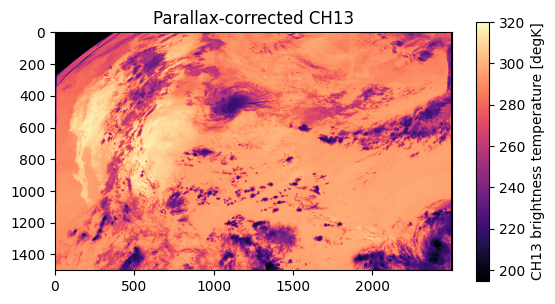

In [ ]:
xind, yind = (np.ravel(plax_dict['xind']), np.ravel(plax_dict['yind']))

plax_corr_ch13 = np.zeros(ch13.shape, dtype=np.float32)
plax_corr_ch13[yind,xind] = np.ravel(ch13)

plt.imshow(plax_corr_ch13, cmap='magma', vmin=195, vmax=320)
plt.title("Parallax-corrected CH13")
plt.colorbar(label="CH13 brightness temperature [degK]", shrink=0.7)

### Visualize the displacement

Let's look at the displacement across the CONUS sector, due to our correction. The units are the number of pixels.

<ipython-input-61-18c1f71fb3b0>:3: RuntimeWarning: invalid value encountered in subtract
  dy = (plax_dict['lat_orig'][:-2, 1:-1]- plax_dict['lat_orig'][2:, 1:-1]) / 2.0
<ipython-input-61-18c1f71fb3b0>:7: RuntimeWarning: invalid value encountered in subtract
  dx = (plax_dict['lon_orig'][1:-1, :-2]- plax_dict['lon_orig'][1:-1, 2:]) / 2.0


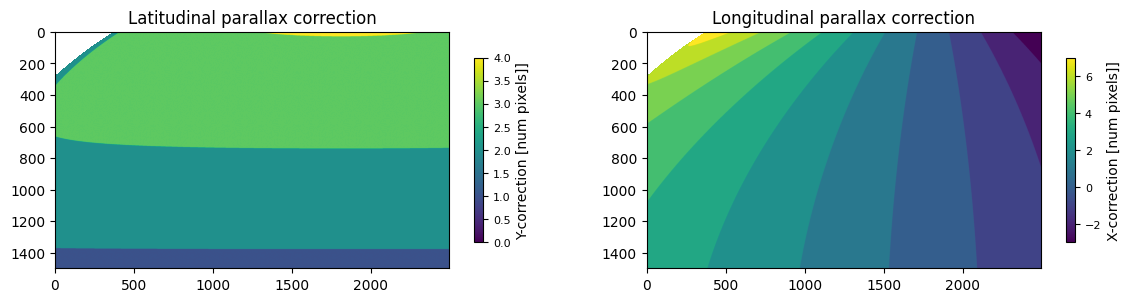

In [ ]:
# Calculate the shifts in pixel-space
latdiff = plax_dict['lat_orig'] - plax_dict['lat_pc']
dy = (plax_dict['lat_orig'][:-2, 1:-1]- plax_dict['lat_orig'][2:, 1:-1]) / 2.0
latshift = np.round(latdiff[1:-1, 1:-1] / dy)

londiff = plax_dict['lon_orig'] - plax_dict['lon_pc']
dx = (plax_dict['lon_orig'][1:-1, :-2]- plax_dict['lon_orig'][1:-1, 2:]) / 2.0
lonshift = np.round(londiff[1:-1, 1:-1] / dx)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

latS = ax[0].imshow(latshift, cmap='viridis')
ax[0].set_title('Latitudinal parallax correction')
cbar1 = fig.colorbar(latS,label='Y-correction [num pixels]]', shrink=0.4)
cbar1.ax.tick_params(labelsize=8)

lonS = ax[1].imshow(lonshift, cmap='viridis')
ax[1].set_title('Longitudinal parallax correction')
cbar2 = fig.colorbar(lonS,label='X-correction [num pixels]]', shrink=0.4)
cbar2.ax.tick_params(labelsize=8)


You can see how over the GOES-East CONUS sector, the longitudinal shift varies much more than the latitudinal shift. In the northwest part of the sector, the latitudinal shift due to our parallax correction is 3 pixels, whereas the longitudinal shift is 4-7 pixels! Keep in mind the pixel area for CH13 in that part of the sector is also quite large.

### Visualize side-by-side

To really see how the data are affected, let's visualize the parallax-corrected data side-by-side with the un-corrected data. Let's zoom in so we can see the differences better.

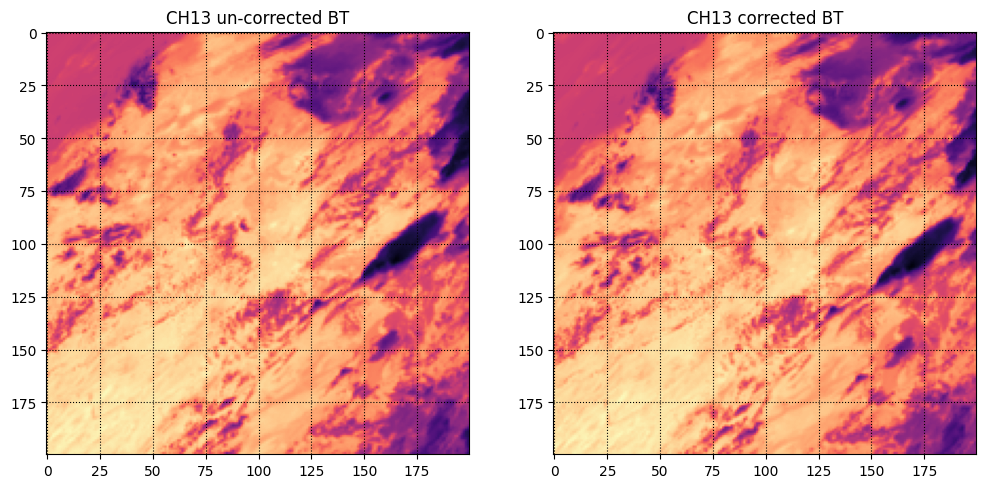

In [ ]:
yslice = slice(200,400)
xslice = slice(300,500)

c13_uncorr_sub = ch13[yslice, xslice]
c13_corr_sub = plax_corr_ch13[yslice, xslice]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

ax[0].imshow(c13_uncorr_sub, vmin=220, vmax=315, cmap="magma")
ax[0].set_title('CH13 un-corrected BT')
ax[0].grid(linestyle=":", color="black")

ax[1].imshow(c13_corr_sub, vmin=220, vmax=315, cmap="magma")
ax[1].set_title('CH13 corrected BT')
ax[1].grid(linestyle=":", color="black")

This side-by-side comparison is from the Northwest U.S., around Oregon and Idaho. Hopefully you can see how the correction "moves" the clouds to the south and east, towards the position of the GOES-16 satellite (75.2 W).

Because we used a constant-cloud-height assumption, the correction is  fairly similar in this entire region. This correction is particularly evident when looking at point `(x,y) = (175,100)`. Notice how much the cold cloud top moved southeastward. Try to find other spots where you can see the effect of the parallax correction.